# Classification of Handwritten digits

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X, y = mnist["data"], mnist["target"]
print("X.shape:", X.shape) # 70,000 images and 784 features which is 28*28 pixels - 0 to 255
print("y.shape:", y.shape)
print(type(X))

X.shape: (70000, 784)
y.shape: (70000,)
<class 'pandas.core.frame.DataFrame'>


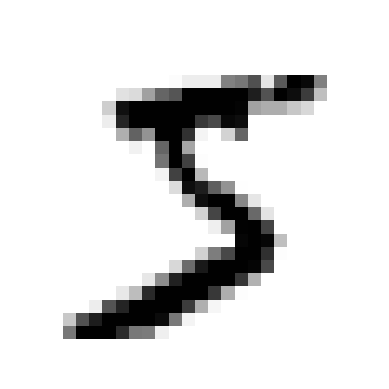

Label:  5


In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].to_numpy()
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
print("Label: ", y[0])

In [11]:
import numpy as np

y = y.astype(np.uint8)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
# 5-detector
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

# Classifying only 5 digits
sgd_clf.fit(X_train, y_train_5)

# now use this model to test one digit which we already knew it is true
sgd_clf.predict([some_digit])

/Users/vinodini/code/hands-on-ml-book/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [15]:
# cross validation custom way
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]

    X_test_folds = X_train.iloc[test_index]
    y_test_folds = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))



0.9669
0.91625
0.96785


In [16]:
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# accuracy of positive predictions, accepts good data
print("Precision score: ", precision_score(y_train_5, y_train_pred))

# How much of TP out of TP + FN, rejects good data
print("Recall score: ", recall_score(y_train_5, y_train_pred))
print("F1 score: ", f1_score(y_train_5, y_train_pred))

Precision score:  0.8370879772350012
Recall score:  0.6511713705958311
F1 score:  0.7325171197343847


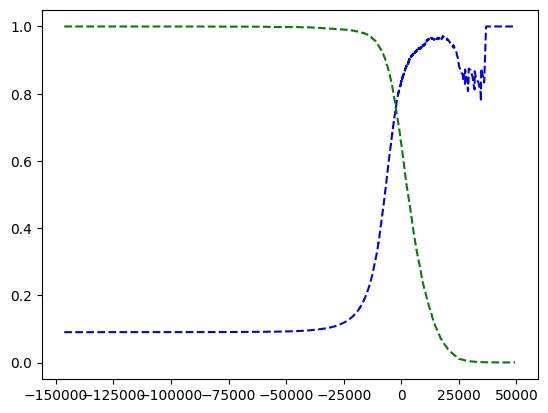

In [21]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_prec_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")

plot_prec_recall(precisions, recalls, thresholds)
plt.show()


In [22]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))


0.8370879772350012
0.6511713705958311


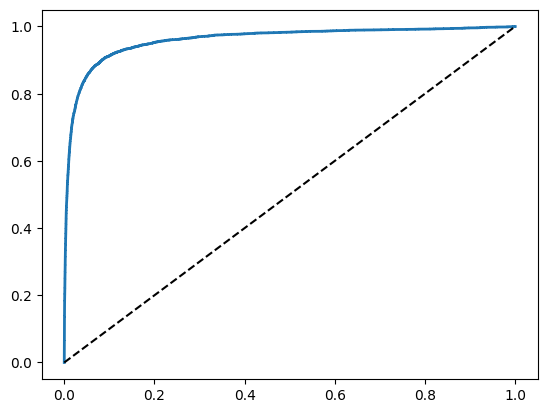

In [24]:
# ROC
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--')
    [...]

plot_roc_curve(fpr, tpr)
plt.show()

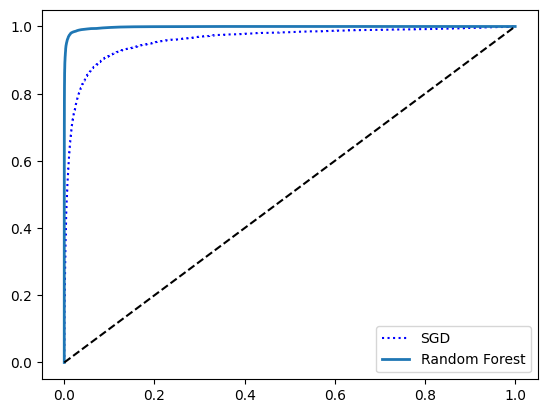

In [25]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [26]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # training all digits
svm_clf.predict([some_digit])

/Users/vinodini/code/hands-on-ml-book/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)